In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 10           # times to run the model on complete data
IM_SIZE = 28
INPUT_DIM = IM_SIZE * IM_SIZE     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 75         # latent vector dimension
N_CLASSES = 10          # number of classes in the data
lr = 1e-3               # learning rate

In [5]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
def idx2onehot(idx, n=N_CLASSES):
    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

In [7]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim + n_classes, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim + n_classes]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        # latent parameters
        mean = self.mu(hidden)
        # mean is of shape [batch_size, latent_dim]
        log_var = self.var(hidden)
        # log_var is of shape [batch_size, latent_dim]

        return mean, log_var

In [8]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, latent_dim, hidden_dim, output_dim, n_classes):
        '''
        Args:
            latent_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the size of output (in case of MNIST 28 * 28).
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.latent_to_hidden = nn.Linear(latent_dim + n_classes, hidden_dim)
        self.hidden_to_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim + num_classes]
        x = F.relu(self.latent_to_hidden(x))
        # x is of shape [batch_size, hidden_dim]
        generated_x = F.sigmoid(self.hidden_to_out(x))
        # x is of shape [batch_size, output_dim]

        return generated_x

In [9]:
class CVAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, input_dim, hidden_dim, latent_dim, n_classes):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
            n_classes: A integer indicating the number of classes. (dimension of one-hot representation of labels)
        '''
        super().__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_classes)

    def forward(self, x, y):

        x = torch.cat((x, y), dim=1)

        # encode
        z_mu, z_var = self.encoder(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        z = torch.cat((x_sample, y), dim=1)

        # decode
        generated_x = self.decoder(z)

        return generated_x, z_mu, z_var

In [10]:
# model
model = CVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, N_CLASSES)
model.to(device)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [11]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    RCL = F.binary_cross_entropy(reconstructed_x, x, size_average=False)
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return RCL + KLD

In [12]:
def train():
    # set the train model
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, y) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # convert y into one-hot encoding
        y = idx2onehot(y.view(-1, 1))
        y = y.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        reconstructed_x, z_mu, z_var = model(x, y)

        # loss
        loss = calculate_loss(x, reconstructed_x, z_mu, z_var)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [13]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, y) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # convert y into one-hot encoding
            y = idx2onehot(y.view(-1, 1))
            y = y.to(device)

            # forward pass
            reconstructed_x, z_mu, z_var = model(x, y)

            # loss
            loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()


            return test_loss

In [14]:
best_test_loss = +np.inf
for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/eromanenkova/anaconda3/envs/my-torch/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 159.28, Test Loss: 0.81
Epoch 1, Train Loss: 121.16, Test Loss: 0.72
Epoch 2, Train Loss: 112.81, Test Loss: 0.69
Epoch 3, Train Loss: 109.08, Test Loss: 0.67
Epoch 4, Train Loss: 106.99, Test Loss: 0.66
Epoch 5, Train Loss: 105.65, Test Loss: 0.65
Epoch 6, Train Loss: 104.69, Test Loss: 0.65
Epoch 7, Train Loss: 104.02, Test Loss: 0.65
Epoch 8, Train Loss: 103.51, Test Loss: 0.64
Epoch 9, Train Loss: 103.02, Test Loss: 0.64


Generating a 4


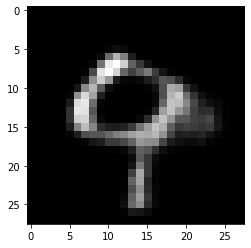

In [15]:
# create a random latent vector
z = torch.randn(1, LATENT_DIM).to(device)

# pick randomly 1 class, for which we want to generate the data
y = torch.randint(0, N_CLASSES, (1, 1)).to(dtype=torch.long)
print(f'Generating a {y.item()}')

y = idx2onehot(y).to(device, dtype=z.dtype)
z = torch.cat((z, y), dim=1)

reconstructed_img = model.decoder(z)
img = reconstructed_img.view(28, 28).data

plt.figure()
plt.imshow(img.detach().cpu().numpy(), cmap='gray')
plt.show()

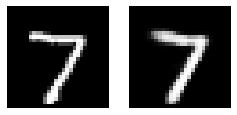

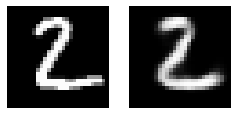

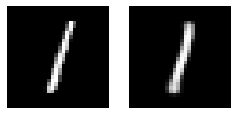

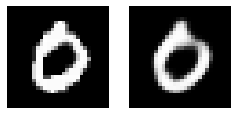

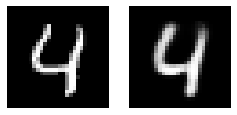

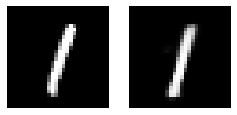

In [16]:
test_iterator = DataLoader(test_dataset, batch_size=1) 
for i, (x, y) in zip(range(6), test_iterator):
    # reshape the data
    x = x.view(-1, 28 * 28)
    x = x.to(device)
    img = x.view(28, 28).data

    # convert y into one-hot encoding
    y = idx2onehot(y.view(-1, 1))
    y = y.to(device)
            
    #     z = torch.randn(1, LATENT_DIM).to(device)

    #     # pick randomly 1 class, for which we want to generate the data
    #     y = torch.randint(0, N_CLASSES, (1, 1)).to(dtype=torch.long)
    #     print(f'Generating a {y.item()}')

    #     y = idx2onehot(y).to(device, dtype=z.dtype)
    #     z = torch.cat((z, y), dim=1)

    reconstructed_img = model(x, y)[0]
    reconstructed_img = reconstructed_img.view(28, 28).data

    fig, axs = plt.subplots(1, 2, figsize=(4, 9))
    axs[0].set_axis_off()
    axs[0].imshow(img.detach().cpu().numpy(), cmap='gray')
    axs[1].set_axis_off()
    axs[1].imshow(reconstructed_img.detach().cpu().numpy(), cmap='gray')
    plt.show()

In [17]:
draw_iterator = DataLoader(test_dataset, batch_size=1, shuffle=True)
second_draw_iterator = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [18]:
def process_pair_xy(x, y):
    x = x.view(-1, 28 * 28)
    x = x.to(device)
    # img = x.view(28, 28).data

    # convert y into one-hot encoding
    y = idx2onehot(y.view(-1, 1))
    y = y.to(device)
    return x, y

In [19]:
def reparameterize_and_sample(z_mu, z_var):
    std = torch.exp(z_var / 2)
    eps = torch.randn_like(std)
    x_sample = eps.mul(std).add_(z_mu)
    
    return x_sample

In [20]:
def apply_model(model, x, y):    
    _, z_mu, z_var = model(x, y)
    x_sample = reparameterize_and_sample(z_mu, z_var)
    return x_sample

In [21]:
def seq_from_pair_imgs(model, first_x, first_y, second_x, second_y, seq_len):
    first_x_sample = apply_model(model, first_x, first_y)
    second_x_sample = apply_model(model, second_x, second_y)

    image_weights = np.linspace(0, 1, seq_len)
    image_sequence = []
    label_sequence = []

    for weight in image_weights:
        intermediate_x = (1 - weight) * first_x_sample + weight * second_x_sample
        intermediate_label = (1 - weight)*first_y + weight*second_y
        z = torch.cat((intermediate_x, intermediate_label), dim=1)
            
        # decode
        generated_intermediate_x = model.decoder(z)
        image_sequence.append(generated_intermediate_x)
        
        label_sequence.append(intermediate_label[0].argmax().item())
                      
    return image_sequence, label_sequence

Correct loading parts of MNIST dataset

In [22]:
test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

In [23]:
import random
random.seed(42)

import torchvision
import os

In [24]:
def save_img_series(path_to_folder, iter_number, img_sequence, label_sequence):
    path_to_directory = os.path.join(path_to_folder, 'img_series_{}'.format(iter_number))
    os.mkdir(path_to_directory)
    for i in range(0, len(img_sequence)):
        path_to_file = os.path.join(path_to_directory, '{}_{}.png'.format(i, label_sequence[i]))

        torchvision.utils.save_image(img_sequence[i].view(IM_SIZE, IM_SIZE), path_to_file)
        #torch.save(img_sequence[i].view(IM_SIZE, IM_SIZE), path_to_file)

In [28]:
#os.mkdir('data/new/1change/normal_data')
#os.mkdir('data/new/1change/with_change')

In [25]:
import itertools

In [26]:
iteration_number = 500
seq_len = 64

In [72]:
digit_1 = 7
digit_2 = 7

In [79]:
# anomaly sequences
idx_1 = torch.tensor(test_dataset.targets) == digit_1
idx_7 = torch.tensor(test_dataset.targets) == digit_2

ones_dataset = torch.utils.data.dataset.Subset(test_dataset, np.where(torch.tensor(test_dataset.targets) ==digit_1)[0])
sevens_dataset = torch.utils.data.dataset.Subset(test_dataset, np.where(torch.tensor(test_dataset.targets) ==digit_2)[0])
        
first_ones_dataloader = DataLoader(ones_dataset, batch_size=1, shuffle=True)
second_ones_dataloader = DataLoader(ones_dataset, batch_size=1, shuffle=True)

first_sevens_dataloader = DataLoader(sevens_dataset, batch_size=1, shuffle=True)
second_sevens_dataloader = DataLoader(sevens_dataset, batch_size=1, shuffle=True)
        
w = np.random.randint(1, 10)
for i, (x, y) in zip(range(1), first_ones_dataloader):
    
    # from 1 to 1
    first_x, first_y = process_pair_xy(x, y)
    second_x, second_y = next(iter(second_ones_dataloader))
    second_x, second_y = process_pair_xy(second_x, second_y)

    first_seq = np.random.randint(1, seq_len//2)
    image_sequence_first_part, labels_first_part = seq_from_pair_imgs(model, first_x, first_y, second_x, second_y, first_seq)
    #print('first part', labels_first_part)
    
    # from 1 to 7
    third_x, third_y = next(iter(first_sevens_dataloader))
    third_x, third_y = process_pair_xy(third_x, third_y)
    
    second_seq = np.random.randint(0, w)
    image_sequence_second_part, labels_second_part = seq_from_pair_imgs(model, second_x, second_y, third_x, third_y, second_seq)
    
    #labels_second_part = list(digit_1 * np.ones(second_seq, dtype=np.int8))
    #print('second part', labels_second_part)
    
    # from 7 to 7
    fourth_x, fourth_y = next(iter(second_sevens_dataloader))
    fourth_x, fourth_y = process_pair_xy(fourth_x, fourth_y)
    
    image_sequence_third_part, labels_third_part = seq_from_pair_imgs(model, third_x, third_y, fourth_x, fourth_y, seq_len - second_seq - first_seq)
    #print('third part', labels_third_part)        
    
    full_image_sequence = image_sequence_first_part + image_sequence_second_part + image_sequence_third_part
    full_labels_sequence = labels_first_part + labels_second_part + labels_third_part
    
    #save_img_series('data/10changes/with_change/', i, full_image_sequence, full_labels_sequence)

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

In [30]:
# normal 
ones_dataset = torch.utils.data.dataset.Subset(test_dataset, np.where(torch.tensor(test_dataset.targets) ==digit_1)[0])
sevens_dataset = torch.utils.data.dataset.Subset(test_dataset, np.where(torch.tensor(test_dataset.targets) ==digit_2)[0])
    
first_ones_dataloader = DataLoader(ones_dataset, batch_size=1, shuffle=True)
second_ones_dataloader = DataLoader(ones_dataset, batch_size=1, shuffle=True)

first_sevens_dataloader = DataLoader(sevens_dataset, batch_size=1, shuffle=True)
second_sevens_dataloader = DataLoader(sevens_dataset, batch_size=1, shuffle=True)
    
first_ones_dataloader = DataLoader(ones_dataset, batch_size=1, shuffle=True)
second_ones_dataloader = DataLoader(ones_dataset, batch_size=1, shuffle=True)

first_sevens_dataloader = DataLoader(sevens_dataset, batch_size=1, shuffle=True)
second_sevens_dataloader = DataLoader(sevens_dataset, batch_size=1, shuffle=True)
    
# normal sequences    
for i, (x, y) in zip(range(4500, 5000), first_ones_dataloader):
    first_x, first_y = process_pair_xy(x, y)
    second_x, second_y = next(iter(second_ones_dataloader))
    second_x, second_y = process_pair_xy(second_x, second_y)

    image_sequence, labels_sequence = seq_from_pair_imgs(model, first_x, first_y,
                                                         second_x, second_y, seq_len)
    save_img_series('data/10changes/normal/', i, image_sequence, labels_sequence)

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


FileExistsError: [Errno 17] File exists: 'data/10changes/normal/img_series_4500'

9
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


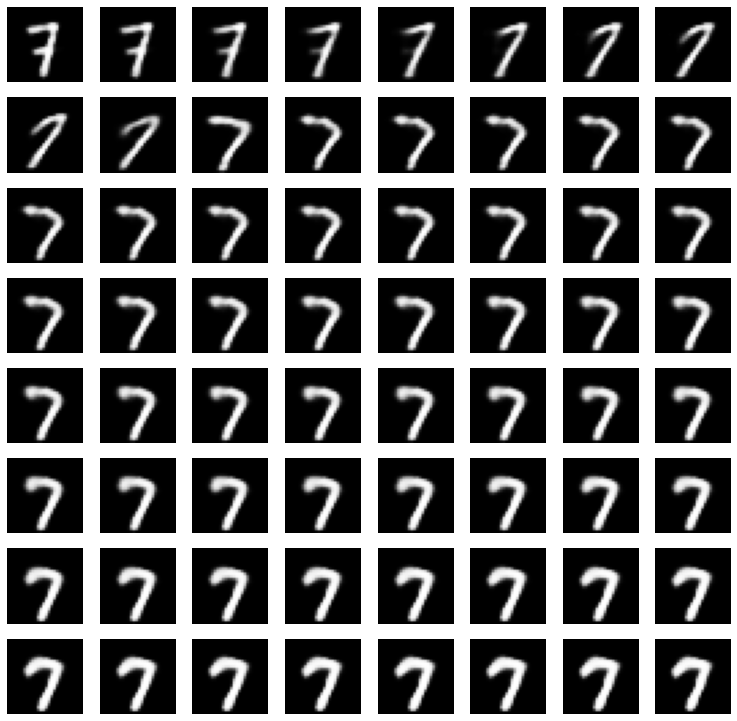

In [81]:
print(w)

print(full_labels_sequence[0:16])
print(full_labels_sequence[16:32])
print(full_labels_sequence[32:48])
print(full_labels_sequence[48:64])

fig, axs = plt.subplots(8, 8, figsize=(13, 13))
for index in range(seq_len):
    first_index = int(index / 8)
    second_index = index % 8
    axs[first_index, second_index].set_axis_off()
    axs[first_index, second_index].imshow(full_image_sequence[index].view(IM_SIZE, 
                                                                          IM_SIZE).detach().cpu().numpy(), cmap='gray')
#plt.savefig('seq_7_7.svg')